# Testing Cox Kan

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sys
from coxkan import CoxKAN
from coxkan.utils import bootstrap_metric, set_seed
from lifelines.utils import concordance_index

SEED = set_seed(42)



In [2]:
df_train = pd.read_csv('/Users/mcgoug01/Downloads/colossus_ihc_imputed_log_scaled_train.csv', index_col=False)
df_test = pd.read_csv('/Users/mcgoug01/Downloads/colossus_ihc_imputed_log_scaled_test.csv', index_col=False)
structure = [15,4,1]


In [3]:

ckan_trained = CoxKAN(seed=42,width=structure) #first digit is number of covariated after one hot encoding cateogrical variables
_ = ckan_trained.train(
    df_train, 
    df_test, 
    duration_col='PFS_months', 
    event_col='PFS_event',
    steps=50)

cindex_pre = bootstrap_metric(ckan_trained.cindex, df_test, N=100)['formatted']
print(f"Pre-symbolic: {cindex_pre}")

ckan_trained.save_ckpt('ckan_trained.ckpt')


train loss: 1.59e+00 | val loss: 1.16e+00: 100%|████████████████████| 50/50 [00:01<00:00, 38.28it/s]


Pre-symbolic: 0.722222 (0.694, 0.750)
Saved model to ckan_trained.ckpt


In [4]:
## pruning based on the training data ONLY - not the test data
train, val = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train['PFS_event'])
pruning_thresholds = np.linspace(0, 0.1, 50)
cindices = []
for threshold in pruning_thresholds:
    ckan_ = CoxKAN(seed=42,width=structure)
    ckan_.load_ckpt('ckan_trained.ckpt')
    _ = ckan_.predict(val) # important forward pass after loading a model
    
    
    prunable = True
    for l in range(ckan_.depth):
        if not (ckan_.acts_scale[l] > threshold).any():
            prunable = False
            break
        
    ckan_ = ckan_.prune_nodes(threshold)
    if 0 in ckan_.width: prunable = False
    try:
        _ = ckan_.predict(val) # important forward pass
        ckan_.prune_edges(threshold, verbose=False)
        cindices.append(ckan_.cindex(val))
    except Exception as e:
        print(f"Error: {e}")
        cindices.append(0)
        prunable = False
    print(f'Pruning threshold: {threshold:.3f}, C-Index (Val): {cindices[-1]:.6f}')
# find the maximum pruning_threshold that is has the highest cindex. If multiple thresholds have the same cindex, take the highest threshold
max_cindex = np.max(cindices)
best_threshold = np.max(pruning_thresholds[cindices == max_cindex])

if np.max(cindices) < 0.51: best_threshold = 0


_ = ckan_trained.predict(df_test)
ckan_trained.prune_edges(best_threshold, verbose=False)
cindex_pruned = bootstrap_metric(ckan_trained.cindex, df_test, N=100)['formatted']
print("\nCoxKAN C-Index (pruned): ", cindex_pruned)
print('pruning threshold: ', best_threshold)


Loading model from ckan_trained.ckpt...
Loaded model from ckan_trained.ckpt
Pruning threshold: 0.000, C-Index (Val): 0.678571
Loading model from ckan_trained.ckpt...
Loaded model from ckan_trained.ckpt
Pruning threshold: 0.002, C-Index (Val): 0.678571
Loading model from ckan_trained.ckpt...
Loaded model from ckan_trained.ckpt
Pruning threshold: 0.004, C-Index (Val): 0.678571
Loading model from ckan_trained.ckpt...
Loaded model from ckan_trained.ckpt
Pruning threshold: 0.006, C-Index (Val): 0.678571
Loading model from ckan_trained.ckpt...
Loaded model from ckan_trained.ckpt
Pruning threshold: 0.008, C-Index (Val): 0.678571
Loading model from ckan_trained.ckpt...
Loaded model from ckan_trained.ckpt
Pruning threshold: 0.010, C-Index (Val): 0.678571
Loading model from ckan_trained.ckpt...
Loaded model from ckan_trained.ckpt
Pruning threshold: 0.012, C-Index (Val): 0.678571
Loading model from ckan_trained.ckpt...
Loaded model from ckan_trained.ckpt
Pruning threshold: 0.014, C-Index (Val): 0


CoxKAN C-Index (symbolic):  0.7222222222222222

PFS Survival risk score =  0.1*CD31_proportional_area - 0.12*CD45_density_mm2 - 0.06*cd68_density_mm2_tumourcore - 0.02*cd68_percent_positive_invasivefront + 0.12*ki67_density_mm2_total_invasive_area + 0.14*ki67_percent_positive_stroma_area + 0.27*sigmoid(4.43*cd68_density_mm2_invasivefront - 4.36) - 0.09*sigmoid(7.34*cd68_density_mm2_tumourcore + 1.45) + 0.02*exp(1.4*cd68_density_mm2_invasivefront) + 0.06*exp(1.0*cd68_percent_positive_invasivefront) + 0.04*exp(1.0*cd68_percent_positive_tumourcore) - 0.03*exp(1.4*ki67_density_mm2_total_invasive_area) - 0.71*exp(-0.94*(-0.17*CD31_percent_positive - 0.19*CD31_proportional_area + 0.21*CD45_percent_positive + 0.08*cd68_density_mm2_invasivefront - 0.07*exp(0.8*cd68_density_mm2_tumourcore) - 0.06*exp(1.0*cd68_percent_positive_tumourcore) - 0.04*exp(1.2*ki67_density_mm2_stroma_area) - 0.12*exp(0.8*ki67_density_mm2_total_invasive_area) - 0.02*exp(1.6*ki67_density_mm2_tumor_area) - 0.06*exp(1.2*k

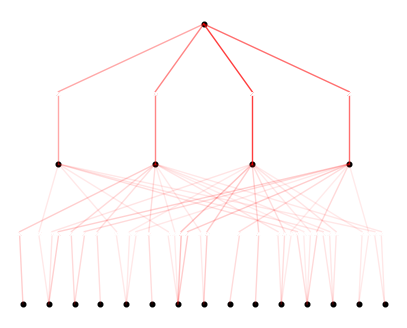

In [5]:
# symbolic function fitting
fit_success = ckan_trained.auto_symbolic(verbose=False)
cindex_symbolic = ckan_trained.cindex(df_test)
print("\nCoxKAN C-Index (symbolic): ", cindex_symbolic)
a = ckan_trained.symbolic_formula(floating_digit=2)[0][0]
print()
print('PFS Survival risk score = ', a)

#print each function at each node in each layer
for l in range(ckan_trained.depth):
    for i in range(ckan_trained.width[l+1]):
        output_actvs = ckan_trained.acts_scale[l][i]
        for j in range(len(output_actvs)):
            if ckan_trained.acts_scale[l][i][j] > 0:
                print(f'Layer {l}, Connection between nodes {j}-{i}: ', ckan_trained.symbolic_fun[l].funs_name[i][j])

fig = ckan_trained.plot()
fig.savefig(f'/Users/mcgoug01/Downloads/ckan_trained.png', dpi=600, bbox_inches='tight')